In [3]:
import numpy as np
import matplotlib.pyplot as plt
import galois
import itertools
from classical_code import *
from quantum_code import *
import stim
from scipy.sparse import lil_matrix
import scipy as sp
from ldpc import BpDecoder, BpOsdDecoder
from ldpc.bplsd_decoder import BpLsdDecoder
from tqdm import tqdm
from result_lifetime import Result, save_new_res
# %load_ext snakeviz

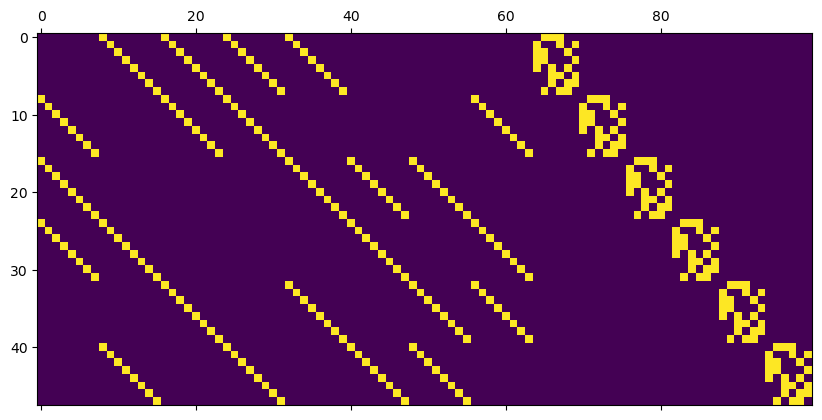

In [265]:
hgp_qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_100_4.qcode")
qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_C422_200_4.qcode")


# hgp_qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_400_16.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_C422_800_16.qcode")


# qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_900_36.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_C642_1350_36.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_C422_1800_36.qcode")

# qcode = read_qcode("../codes/qcodes/HGP_1600_64/HGP_1600_64.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_C642_2400_64.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_C422_3200_64.qcode")

# qcode = read_qcode("../codes/qcodes/HGP_STEANE_700_4.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_STEANE_2800_16.qcode")


# concatenate_iceberg(qcode, 6, "../codes/qcodes/")
# concatenate_iceberg(qcode, 4, "../codes/qcodes/")
# concatenate_steane(qcode, "../codes/qcodes/")


hgp_Hx, hgp_Hz, hgp_Lx, hgp_Lz, _ = hgp_qcode.to_numpy()
Hx, Hz, Lx, Lz, mapping = qcode.to_numpy()


qubit_error_rate = 0.05
meas_error_rate = 0.0

stab_type = True
tanner = True if meas_error_rate else False

H = Hx if stab_type else Hz
hgp_H = hgp_Hx if stab_type else hgp_Hz

qed_dec_H = H[:qcode.qedxm]
qed_channel_probs = [qubit_error_rate]*H.shape[1]

if tanner:
    qec_dec_H = np.hstack([hgp_H, np.eye(hgp_H.shape[0], dtype=int)])
    qec_channel_probs = [qubit_error_rate]*hgp_H.shape[1] + [meas_error_rate]*(hgp_H.shape[0])
else:
    qec_dec_H = hgp_H
    qec_channel_probs = [qubit_error_rate]*hgp_H.shape[1]
L = Lx if stab_type else Lz

plt.matshow(qec_dec_H)
# print(np.count_nonzero(Hx, axis=1))

In [266]:
overlapping_x_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedxm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedxm,qcode.xm):
        if np.any(Hx[i] & Hx[j]): tmp = np.append(tmp, j)
    overlapping_x_generators[i] = tmp

overlapping_z_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedzm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedzm,qcode.zm):
        if np.any(Hz[i] & Hz[j]): tmp = np.append(tmp, j)
    overlapping_z_generators[i] = tmp

def get_overlapping(measurements, gen_type=False, not_overlapping=False):
    overlapping_generators = overlapping_x_generators if gen_type else overlapping_z_generators
    gens_to_measure = set()
    for g in np.where(measurements)[0]:
        gens_to_measure |= set(overlapping_generators[g])

    if not_overlapping:
        return np.array(list(set(np.arange(qcode.qedxm,qcode.xm)) ^ gens_to_measure), dtype=int)
    else:
        return np.array(list(gens_to_measure), dtype=int)

def iceberglogicals(n):
    icebergX = np.zeros(shape=(n-2,2), dtype=int)
    icebergZ = np.zeros(shape=(n-2,2), dtype=int)

    for i in range(n-2):
        icebergX[i] = np.array([0,i+1])
        icebergZ[i] = np.array([i+1,n-1])

    return icebergX, icebergZ
icebergX, icebergZ = iceberglogicals(4)

In [267]:
if (qcode.qedzm):
    bp_qed_dec = BpDecoder(
        qed_dec_H,
        channel_probs=qed_channel_probs,
        max_iter=10,
        bp_method="ps",
        # schedule="serial"
    )

bposd_qec_dec = BpDecoder(
    qec_dec_H,
    channel_probs=qec_channel_probs,
    bp_method="ms",
    max_iter=100,
    # osd_method="osd0",
    # osd_order=4 #the osd search depth
)

def decode(curr_qubit_error, curr_synd_error, concat, adaptive):
    # guessed_error = np.zeros(H.shape[1], dtype=int)
    curr_synd = ((H @ curr_qubit_error) % 2) ^ curr_synd_error
    updated_synd = curr_synd.copy()
    # non_overlapping_gens = get_overlapping(curr_synd[:qcode.qedzm], True, True)
    # if (len(non_overlapping_gens)):
    #     updated_synd[non_overlapping_gens] = 0

    if (concat == 0):
        # QEC only
        if (adaptive == 1):
            curr_qubit_error ^= bposd_qec_dec.decode(updated_synd[qcode.qedzm:])
        else:
            curr_qubit_error ^= bposd_qec_dec.decode(curr_synd[qcode.qedzm:])
    elif (concat == 1):
        # QED + QEC
        curr_qed_synd = curr_synd[:qcode.qedxm]
        curr_hgp_synd = curr_synd[qcode.qedxm:]

        block_correction = np.array([0,0,0,1], dtype=int) if stab_type else np.array([1,0,0,0], dtype=int)
        corrections = np.concatenate([block_correction if x == 1 else np.zeros(4, dtype=int) for x in curr_qed_synd])
        curr_qubit_error ^= corrections

        #######################
        new_channel_probs = 0.0003 * np.ones(hgp_H.shape[1])
        new_channel_probs[mapping[curr_qed_synd == 1].flatten()] = 0.25
        if tanner: new_channel_probs = np.concatenate([new_channel_probs, [meas_error_rate]*hgp_H.shape[0]])
        bposd_qec_dec.update_channel_probs(new_channel_probs)
        ########################

        logical_correction = bposd_qec_dec.decode(curr_hgp_synd)[:hgp_H.shape[1]]
        physical_correction = np.zeros(Hx.shape[1], dtype=int)

        for c in np.where(logical_correction)[0]:
                iceberg_block = np.where(mapping == c)[0][0]
                iceberg_log = np.where(mapping == c)[1][0]
                if stab_type:
                        physical_correction[icebergZ[iceberg_log]+(4*iceberg_block)] ^= 1
                else:
                        physical_correction[icebergX[iceberg_log]+(4*iceberg_block)] ^= 1

        curr_qubit_error ^= physical_correction
        # if (adaptive == 1):
        #     guessed_error = bposd_qed_qec_dec.decode(updated_synd[qcode.qedzm:])
        # else:
        #     guessed_error = bposd_qed_qec_dec.decode(curr_synd[qcode.qedzm:])

    return curr_qubit_error.astype(int)

In [268]:
# np.random.seed(0)

num_iters = 1000
concat = 1 if qcode.qedxm else 0
adaptive = 0
successes = 0

synd = []
errors = []

for ii in tqdm(range(1,num_iters+1)):
    curr_qubit_error = np.zeros(H.shape[1], dtype=int)

    success = 1
    for jj in range(10):
        new_qubit_error = np.random.choice([0, 1], size=H.shape[1], p=[1-qubit_error_rate, qubit_error_rate])
        new_synd_error = np.random.choice([0, 1], size=H.shape[0], p=[1-meas_error_rate, meas_error_rate])
        curr_qubit_error ^= new_qubit_error

        # curr_synd = ((H @ curr_qubit_error) % 2) ^ new_synd_error
        curr_qubit_error = decode(curr_qubit_error, new_synd_error, concat, adaptive)
        # curr_qubit_error ^= guessed_error[:H.shape[1]]


    curr_qubit_error = decode(curr_qubit_error, np.zeros(H.shape[0], dtype=int), concat, 0)
    # curr_qubit_error ^= guessed_error[:H.shape[1]]
    # curr_synd = ((H @ curr_qubit_error) % 2)

    obs = (L @ curr_qubit_error) % 2

    if np.any(obs): # or np.any(curr_synd):
        success = 0
        errors.append(new_qubit_error)

    successes += success

print()
print(1-successes/num_iters)

100%|██████████| 1000/1000 [00:03<00:00, 325.35it/s]


0.6639999999999999


In [198]:
for e in errors:
    print(np.where(e))

(array([ 11,  12,  15,  17,  23,  77,  87, 159], dtype=int64),)
(array([ 12,  13,  86, 173], dtype=int64),)


In [7]:
def iceberglogicals(n):
    icebergX = np.zeros(shape=(n-2,2), dtype=int)
    icebergZ = np.zeros(shape=(n-2,2), dtype=int)

    for i in range(n-2):
        icebergX[i] = np.array([0,i+1])
        icebergZ[i] = np.array([i+1,n-1])

    return icebergX, icebergZ

icebergx, icebergz = iceberglogicals(4)
print(icebergx)
print()
print(icebergz)
print()
print(mapping)

[[0 1]
 [0 2]]

[[1 3]
 [2 3]]

[[  0  17]
 [ 34  51]
 [ 68  85]
 [102 119]
 [136 153]
 [170 187]
 [204 221]
 [238 255]
 [256 269]
 [282 295]
 [308 321]
 [334 347]
 [360 373]
 [386 399]
 [  1  16]
 [  2  32]
 [  3  48]
 [  4  64]
 [  5  80]
 [  6  96]
 [  7 112]
 [  8 128]
 [  9 144]
 [ 10 160]
 [ 11 176]
 [ 12 192]
 [ 13 208]
 [ 14 224]
 [ 15 240]
 [ 18  33]
 [ 19  49]
 [ 20  65]
 [ 21  81]
 [ 22  97]
 [ 23 113]
 [ 24 129]
 [ 25 145]
 [ 26 161]
 [ 27 177]
 [ 28 193]
 [ 29 209]
 [ 30 225]
 [ 31 241]
 [ 35  50]
 [ 36  66]
 [ 37  82]
 [ 38  98]
 [ 39 114]
 [ 40 130]
 [ 41 146]
 [ 42 162]
 [ 43 178]
 [ 44 194]
 [ 45 210]
 [ 46 226]
 [ 47 242]
 [ 52  67]
 [ 53  83]
 [ 54  99]
 [ 55 115]
 [ 56 131]
 [ 57 147]
 [ 58 163]
 [ 59 179]
 [ 60 195]
 [ 61 211]
 [ 62 227]
 [ 63 243]
 [ 69  84]
 [ 70 100]
 [ 71 116]
 [ 72 132]
 [ 73 148]
 [ 74 164]
 [ 75 180]
 [ 76 196]
 [ 77 212]
 [ 78 228]
 [ 79 244]
 [ 86 101]
 [ 87 117]
 [ 88 133]
 [ 89 149]
 [ 90 165]
 [ 91 181]
 [ 92 197]
 [ 93 213]
 [ 94 229]


In [177]:
curr_qubit_error = np.zeros(H.shape[1], dtype=int)
new_qubit_error = np.zeros(H.shape[1], dtype=int)
new_qubit_error[np.array([ 4], dtype=int)] = 1
new_synd_error = np.zeros(H.shape[0], dtype=int)
# new_synd_error[np.array([  1, 114, 325, 326, 346])] = 1
curr_qubit_error ^= new_qubit_error

curr_synd = ((H[:qcode.qedxm] @ curr_qubit_error) % 2)# ^ new_synd_error
curr_hgp_synd = ((H[qcode.qedxm:] @ curr_qubit_error) % 2)
print(np.where(curr_synd)[0], np.where(curr_hgp_synd)[0])

block_correction = np.array([0,0,0,1], dtype=int) if stab_type else np.array([1,0,0,0], dtype=int)
corrections = np.concatenate([block_correction if x == 1 else np.zeros(4, dtype=int) for x in curr_synd])
curr_qubit_error ^= corrections

_ = bp_qed_dec.decode(curr_synd[:qcode.qedzm])
new_channel_probs = 1 / (np.exp(bp_qed_dec.log_prob_ratios) + 1)
# bposd_qec_dec.update_channel_probs(new_channel_probs)

# new_channel_probs = np.zeros(hgp_H.shape[1])
# new_channel_probs[mapping[curr_synd == 1].flatten()] = 0.25
# bposd_qec_dec.update_channel_probs(new_channel_probs)

print(np.where(curr_qubit_error)[0])

[1] [ 2  3 10 11 34 43]
[4 7]


In [178]:
new_channel_probs

array([0.00030591, 0.00030591, 0.00030591, 0.00030591, 0.25005101,
       0.25005101, 0.25005101, 0.25005101, 0.00030591, 0.00030591,
       0.00030591, 0.00030591, 0.00030591, 0.00030591, 0.00030591,
       0.00030591, 0.00030591, 0.00030591, 0.00030591, 0.00030591,
       0.00030591, 0.00030591, 0.00030591, 0.00030591, 0.00030591,
       0.00030591, 0.00030591, 0.00030591, 0.00030591, 0.00030591,
       0.00030591, 0.00030591, 0.00030591, 0.00030591, 0.00030591,
       0.00030591, 0.00030591, 0.00030591, 0.00030591, 0.00030591,
       0.00030591, 0.00030591, 0.00030591, 0.00030591, 0.00030591,
       0.00030591, 0.00030591, 0.00030591, 0.00030591, 0.00030591,
       0.00030591, 0.00030591, 0.00030591, 0.00030591, 0.00030591,
       0.00030591, 0.00030591, 0.00030591, 0.00030591, 0.00030591,
       0.00030591, 0.00030591, 0.00030591, 0.00030591, 0.00030591,
       0.00030591, 0.00030591, 0.00030591, 0.00030591, 0.00030591,
       0.00030591, 0.00030591, 0.00030591, 0.00030591, 0.00030

In [10]:
logical_correction = bposd_qec_dec.decode(hgp_synd)
print(logical_correction)
print(bposd_qec_dec.converge)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
True


In [265]:
physical_correction = np.zeros(Hx.shape[1], dtype=int)

for c in np.where(logical_correction)[0]:
        iceberg_block = np.where(mapping == c)[0][0]
        iceberg_log = np.where(mapping == c)[1][0]
        if stab_type:
                physical_correction[icebergz[iceberg_log]+(4*iceberg_block)] ^= 1
        else:
                physical_correction[icebergx[iceberg_log]+(4*iceberg_block)] ^= 1

print(np.where(physical_correction)[0])

[5 6]


In [84]:
err = np.zeros(hgp_H.shape[1])
err[0] = 1
synd = (hgp_H @ err) % 2

# np.where(bposd_qec_dec.decode(synd))
print(np.where((hgp_H @ err) % 2))

(array([ 8, 16, 24], dtype=int64),)


In [262]:
np.where(hgp_H[3])

(array([11, 19, 27, 35, 64, 65, 69], dtype=int64),)

In [263]:
np.where(H[qcode.qedxm:][3])

(array([  4,   6,  16,  17,  60,  61,  80,  81, 100, 102, 140, 141, 156,
        157], dtype=int64),)

In [146]:
x = 11
iceberg_block = np.where(mapping == x)[0][0]
iceberg_log = np.where(mapping == x)[1][0]
# print(iceberg_block, iceberg_log)
print(iceberg_block, iceberg_log)

15 0
